In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
from tqdm import tqdm
import keras
from keras.datasets import mnist, cifar10, fashion_mnist

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
def cv2_rotate(image, degrees):
    if len(image.shape) == 3:
        rows, cols, _ = image.shape
    else:
        rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    return cv2.warpAffine(image, M, (cols,rows))

In [5]:
def pad(image, padding=2):
    
    h, w = image.shape
    image_padded = np.zeros((h + 2*padding, w + 2*padding))
    image_padded[padding:-padding, padding:-padding] = image
    return image_padded

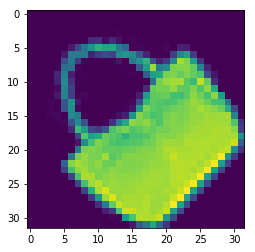

In [6]:
plt.imshow(cv2_rotate(pad(X_train[100]), 45))

In [7]:
augmented_rotations_per_sample = 3

In [8]:
def generate_random_rotations(X, Y, n_rotations_per_sample, rot_range=10):
    
    new_X = []
    new_Y = []
    rotations = []
    
    h, w = X.shape[1:]
    bigger = 2
    
    for image, label in tqdm(zip(X, Y), total=len(X)):
        
        image = pad(image)
        
        for _ in range(n_rotations_per_sample):
            
            rotation = np.random.randint(-rot_range, rot_range+1)
            rotated_image = cv2_rotate(image, rotation)
            new_X.append(rotated_image)
            new_Y.append(label)
            rotations.append(rotation)
    
    new_X = np.array(new_X)
    if len(new_X.shape) == 3:
        new_X = np.expand_dims(new_X, 3)
        
    return new_X, np.array(new_Y), np.array(rotations)

In [9]:
X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, augmented_rotations_per_sample)
X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, augmented_rotations_per_sample)

Y_train_onehot = keras.utils.to_categorical(Y_train_rot)
Y_test_onehot = keras.utils.to_categorical(Y_test_rot)

100%|██████████| 10000/10000 [00:00<00:00, 14493.85it/s]


In [10]:
nb_classes = Y_train_onehot.shape[1]

In [11]:
R_train_radians, R_test_radians = (R * np.pi / 180 for R in (R_train, R_test))

In [12]:
def create_rot_sin_cos(R_radians):
    rot_sin_cos = np.empty((len(R_radians), 2))
    rot_sin_cos[:, 0] = np.sin(R_radians)
    rot_sin_cos[:, 1] = np.cos(R_radians)
    return rot_sin_cos

In [13]:
R_train_sin_cos = create_rot_sin_cos(R_train_radians)
R_test_sin_cos = create_rot_sin_cos(R_test_radians)

In [14]:
from keras import layers
from keras import models
import keras.backend as K

def build_model(use_labels=True, use_rotation=True):

    input_layer = layers.Input(X_train_rot.shape[1:], name='image_input')
    x = input_layer

    x = layers.Conv2D(32, (3,3), activation='relu')(x)
    x = layers.Conv2D(32, (3,3), activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    flatten = layers.Flatten()(x)
    
    if use_labels:
        y = layers.Dense(128, activation='relu')(flatten)
        y = layers.Dropout(0.5)(y)
        y = layers.Dense(nb_classes, activation='softmax', name='y')(y)

    if use_rotation:
        r = layers.Dense(32, activation='relu')(flatten)
        r = layers.Dropout(0.5)(r)
        r = layers.Dense(2, name='r')(r)

    if use_labels and use_rotation:
        model = models.Model(input_layer, [y, r])        
        model.compile(optimizer='adam', loss=['categorical_crossentropy', 'cosine_proximity'], 
                      metrics=['accuracy'], loss_weights=[alpha, beta])
    elif use_labels:
        model = models.Model(input_layer, y)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    elif use_rotation:
        model = models.Model(input_layer, r)
        model.compile(optimizer='adam', loss='cosine_proximity', metrics=['accuracy'])
    else:
        raise ValueError('Specify at least 1 output for the network!')
        
    #model.summary()
    
    return model

In [15]:
from keras import callbacks

class LossWeightsCallback(callbacks.Callback):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 1:
            self.alpha = self.alpha - 0.4 # set to 0.5
            self.beta = self.beta + 0.4 # set to 0.5

In [16]:
def train_model(model, use_labels=True, use_rotation=True):
    
    if use_labels and use_rotation:
        y_train = [Y_train_onehot, R_train_sin_cos]
        y_test = [Y_test_onehot, R_test_sin_cos]
    elif use_labels:
        y_train = Y_train_onehot
        y_test = Y_test_onehot
    elif use_rotation:
        y_train = R_train_sin_cos
        y_test = R_test_sin_cos
    else:
        raise ValueError('Specify output for training')
        
    
    early_stopper = callbacks.EarlyStopping(patience=1)
    
    if use_labels and use_rotation:
        lw_callback = LossWeightsCallback(alpha, beta)
        _callbacks = [early_stopper, lw_callback]
    else:
        _callbacks = [early_stopper]
    
    return model.fit(X_train_rot, y_train, 
                     validation_data=(X_test_rot, y_test), 
                     callbacks=_callbacks,
                     batch_size=256,
                     epochs=10)

In [17]:
histories = []

use_labels = True
use_rotation = True

rot_step = 10

for rot_range in range(0, 180 + rot_step, rot_step):
    
    print('Training on rotation range of +-', rot_range)

    X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, 
                                                                  augmented_rotations_per_sample, rot_range)
    X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, 
                                                               augmented_rotations_per_sample, rot_range)

    Y_train_onehot = keras.utils.to_categorical(Y_train_rot)
    Y_test_onehot = keras.utils.to_categorical(Y_test_rot)

    nb_classes = Y_train_onehot.shape[1]

    R_train_radians, R_test_radians = (R * np.pi / 180 for R in (R_train, R_test))

    R_train_sin_cos = create_rot_sin_cos(R_train_radians)
    R_test_sin_cos = create_rot_sin_cos(R_test_radians)

    alpha = K.variable(0.9)
    beta = K.variable(0.1)
    model = build_model(use_labels, use_rotation)

    history = train_model(model, use_labels, use_rotation).history
    histories.append(history)


  5%|▌         | 3125/60000 [00:00<00:03, 15619.35it/s]

Training on rotation range of +- 0


100%|██████████| 10000/10000 [00:00<00:00, 15602.50it/s]


Instructions for updating:
dim is deprecated, use axis instead
Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 26s 145us/step - loss: 0.6846 - y_loss: 0.8712 - r_loss: -0.9950 - y_acc: 0.8274 - r_acc: 0.9984 - val_loss: 0.1663 - val_y_loss: 0.2958 - val_r_loss: -1.0000 - val_y_acc: 0.8899 - val_r_acc: 1.0000
Epoch 2/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.1555 - y_loss: 0.2839 - r_loss: -1.0000 - y_acc: 0.8942 - r_acc: 1.0000 - val_loss: 0.1366 - val_y_loss: 0.2628 - val_r_loss: -1.0000 - val_y_acc: 0.9033 - val_r_acc: 1.0000
Epoch 3/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.1132 - y_loss: 0.2368 - r_loss: -1.0000 - y_acc: 0.9100 - r_acc: 1.0000 - val_loss: 0.1265 - val_y_loss: 0.2517 - val_r_loss: -1.0000 - val_y_acc: 0.9080 - val_r_acc: 1.0000
Epoch 4/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.0866 - y_loss: 0.2073 - 

  3%|▎         | 1522/60000 [00:00<00:03, 15208.27it/s]

Training on rotation range of +- 10


100%|██████████| 10000/10000 [00:00<00:00, 14797.10it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 22s 124us/step - loss: 0.7162 - y_loss: 0.9062 - r_loss: -0.9943 - y_acc: 0.8056 - r_acc: 0.9997 - val_loss: 0.2049 - val_y_loss: 0.3387 - val_r_loss: -0.9992 - val_y_acc: 0.8740 - val_r_acc: 1.0000
Epoch 2/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.2161 - y_loss: 0.3511 - r_loss: -0.9985 - y_acc: 0.8690 - r_acc: 1.0000 - val_loss: 0.1800 - val_y_loss: 0.3110 - val_r_loss: -0.9992 - val_y_acc: 0.8836 - val_r_acc: 1.0000
Epoch 3/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.1804 - y_loss: 0.3114 - r_loss: -0.9988 - y_acc: 0.8828 - r_acc: 1.0000 - val_loss: 0.1552 - val_y_loss: 0.2835 - val_r_loss: -0.9994 - val_y_acc: 0.8944 - val_r_acc: 1.0000
Epoch 4/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.1557 - y_loss: 0.2840 - r_loss: -0.9989 - y_acc: 0.8926 - r_acc: 1.0000 - val_loss: 0.1

  2%|▏         | 1478/60000 [00:00<00:03, 14772.41it/s]

Training on rotation range of +- 20


100%|██████████| 10000/10000 [00:00<00:00, 14761.01it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 125us/step - loss: 0.6594 - y_loss: 0.8427 - r_loss: -0.9900 - y_acc: 0.7911 - r_acc: 0.9994 - val_loss: 0.2410 - val_y_loss: 0.3787 - val_r_loss: -0.9983 - val_y_acc: 0.8605 - val_r_acc: 1.0000
Epoch 2/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.2557 - y_loss: 0.3949 - r_loss: -0.9966 - y_acc: 0.8546 - r_acc: 1.0000 - val_loss: 0.2020 - val_y_loss: 0.3354 - val_r_loss: -0.9987 - val_y_acc: 0.8747 - val_r_acc: 1.0000
Epoch 3/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.2131 - y_loss: 0.3476 - r_loss: -0.9970 - y_acc: 0.8705 - r_acc: 1.0000 - val_loss: 0.1799 - val_y_loss: 0.3109 - val_r_loss: -0.9988 - val_y_acc: 0.8857 - val_r_acc: 1.0000
Epoch 4/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.1859 - y_loss: 0.3174 - r_loss: -0.9972 - y_acc: 0.8803 - r_acc: 1.0000 - val_loss: 0.1

  2%|▏         | 1482/60000 [00:00<00:03, 14808.12it/s]

Training on rotation range of +- 30


100%|██████████| 10000/10000 [00:00<00:00, 13932.06it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 125us/step - loss: 1.2212 - y_loss: 1.4664 - r_loss: -0.9856 - y_acc: 0.7431 - r_acc: 0.9983 - val_loss: 0.2751 - val_y_loss: 0.4165 - val_r_loss: -0.9976 - val_y_acc: 0.8463 - val_r_acc: 1.0000
Epoch 2/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.3045 - y_loss: 0.4489 - r_loss: -0.9948 - y_acc: 0.8372 - r_acc: 1.0000 - val_loss: 0.2358 - val_y_loss: 0.3729 - val_r_loss: -0.9980 - val_y_acc: 0.8649 - val_r_acc: 1.0000
Epoch 3/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.2581 - y_loss: 0.3974 - r_loss: -0.9955 - y_acc: 0.8535 - r_acc: 1.0000 - val_loss: 0.2118 - val_y_loss: 0.3463 - val_r_loss: -0.9983 - val_y_acc: 0.8713 - val_r_acc: 1.0000
Epoch 4/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.2287 - y_loss: 0.3648 - r_loss: -0.9958 - y_acc: 0.8649 - r_acc: 1.0000 - val_loss: 0.1

  2%|▏         | 1448/60000 [00:00<00:04, 14470.60it/s]

Training on rotation range of +- 40


100%|██████████| 10000/10000 [00:00<00:00, 14050.11it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 125us/step - loss: 1.2906 - y_loss: 1.5420 - r_loss: -0.9721 - y_acc: 0.7236 - r_acc: 0.9975 - val_loss: 0.2988 - val_y_loss: 0.4425 - val_r_loss: -0.9943 - val_y_acc: 0.8314 - val_r_acc: 1.0000
Epoch 2/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.3228 - y_loss: 0.4685 - r_loss: -0.9886 - y_acc: 0.8259 - r_acc: 1.0000 - val_loss: 0.2459 - val_y_loss: 0.3840 - val_r_loss: -0.9971 - val_y_acc: 0.8537 - val_r_acc: 1.0000
Epoch 3/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.2784 - y_loss: 0.4194 - r_loss: -0.9907 - y_acc: 0.8438 - r_acc: 1.0000 - val_loss: 0.2278 - val_y_loss: 0.3638 - val_r_loss: -0.9970 - val_y_acc: 0.8616 - val_r_acc: 1.0000
Epoch 4/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.2480 - y_loss: 0.3857 - r_loss: -0.9915 - y_acc: 0.8561 - r_acc: 1.0000 - val_loss: 0.2

  2%|▏         | 1416/60000 [00:00<00:04, 14146.08it/s]

Training on rotation range of +- 50


100%|██████████| 10000/10000 [00:00<00:00, 12867.79it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 126us/step - loss: 1.0815 - y_loss: 1.3089 - r_loss: -0.9652 - y_acc: 0.7216 - r_acc: 0.9386 - val_loss: 0.3047 - val_y_loss: 0.4487 - val_r_loss: -0.9912 - val_y_acc: 0.8327 - val_r_acc: 0.9409
Epoch 2/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.3454 - y_loss: 0.4929 - r_loss: -0.9822 - y_acc: 0.8187 - r_acc: 0.9429 - val_loss: 0.2687 - val_y_loss: 0.4088 - val_r_loss: -0.9916 - val_y_acc: 0.8481 - val_r_acc: 0.9432
Epoch 3/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.2973 - y_loss: 0.4397 - r_loss: -0.9845 - y_acc: 0.8376 - r_acc: 0.9435 - val_loss: 0.2308 - val_y_loss: 0.3668 - val_r_loss: -0.9940 - val_y_acc: 0.8652 - val_r_acc: 0.9409
Epoch 4/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.2642 - y_loss: 0.4031 - r_loss: -0.9862 - y_acc: 0.8502 - r_acc: 0.9421 - val_loss: 0.2

  2%|▏         | 1454/60000 [00:00<00:04, 14537.90it/s]

Training on rotation range of +- 60


100%|██████████| 10000/10000 [00:00<00:00, 14217.07it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 126us/step - loss: 1.2907 - y_loss: 1.5384 - r_loss: -0.9385 - y_acc: 0.6930 - r_acc: 0.8843 - val_loss: 0.3340 - val_y_loss: 0.4800 - val_r_loss: -0.9797 - val_y_acc: 0.8256 - val_r_acc: 0.9079
Epoch 2/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.3823 - y_loss: 0.5324 - r_loss: -0.9685 - y_acc: 0.8055 - r_acc: 0.9137 - val_loss: 0.2882 - val_y_loss: 0.4299 - val_r_loss: -0.9869 - val_y_acc: 0.8430 - val_r_acc: 0.9574
Epoch 3/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.3264 - y_loss: 0.4709 - r_loss: -0.9737 - y_acc: 0.8257 - r_acc: 0.9245 - val_loss: 0.2568 - val_y_loss: 0.3952 - val_r_loss: -0.9887 - val_y_acc: 0.8539 - val_r_acc: 0.9630
Epoch 4/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.2947 - y_loss: 0.4359 - r_loss: -0.9765 - y_acc: 0.8378 - r_acc: 0.9319 - val_loss: 0.2

  2%|▏         | 1449/60000 [00:00<00:04, 14481.90it/s]

Training on rotation range of +- 70


100%|██████████| 10000/10000 [00:00<00:00, 14203.68it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 127us/step - loss: 1.2078 - y_loss: 1.4442 - r_loss: -0.9207 - y_acc: 0.6831 - r_acc: 0.8944 - val_loss: 0.3570 - val_y_loss: 0.5048 - val_r_loss: -0.9738 - val_y_acc: 0.8147 - val_r_acc: 0.9597
Epoch 2/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.4121 - y_loss: 0.5641 - r_loss: -0.9564 - y_acc: 0.7935 - r_acc: 0.9248 - val_loss: 0.2998 - val_y_loss: 0.4421 - val_r_loss: -0.9809 - val_y_acc: 0.8347 - val_r_acc: 0.9662
Epoch 3/10
180000/180000 [==============================] - 22s 124us/step - loss: 0.3535 - y_loss: 0.4999 - r_loss: -0.9636 - y_acc: 0.8149 - r_acc: 0.9321 - val_loss: 0.2808 - val_y_loss: 0.4212 - val_r_loss: -0.9834 - val_y_acc: 0.8438 - val_r_acc: 0.9683
Epoch 4/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.3199 - y_loss: 0.4630 - r_loss: -0.9680 - y_acc: 0.8290 - r_acc: 0.9394 - val_loss: 0.2

  2%|▏         | 1476/60000 [00:00<00:03, 14742.44it/s]

Training on rotation range of +- 80


100%|██████████| 10000/10000 [00:00<00:00, 13491.43it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 127us/step - loss: 0.7934 - y_loss: 0.9845 - r_loss: -0.9265 - y_acc: 0.7036 - r_acc: 0.9123 - val_loss: 0.3640 - val_y_loss: 0.5119 - val_r_loss: -0.9672 - val_y_acc: 0.8145 - val_r_acc: 0.9446
Epoch 2/10
180000/180000 [==============================] - 22s 122us/step - loss: 0.4076 - y_loss: 0.5590 - r_loss: -0.9544 - y_acc: 0.7957 - r_acc: 0.9367 - val_loss: 0.3045 - val_y_loss: 0.4470 - val_r_loss: -0.9775 - val_y_acc: 0.8373 - val_r_acc: 0.9629
Epoch 3/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.3512 - y_loss: 0.4971 - r_loss: -0.9618 - y_acc: 0.8172 - r_acc: 0.9430 - val_loss: 0.2738 - val_y_loss: 0.4134 - val_r_loss: -0.9822 - val_y_acc: 0.8474 - val_r_acc: 0.9674
Epoch 4/10
180000/180000 [==============================] - 22s 125us/step - loss: 0.3190 - y_loss: 0.4619 - r_loss: -0.9666 - y_acc: 0.8295 - r_acc: 0.9470 - val_loss: 0.2

  2%|▏         | 1424/60000 [00:00<00:04, 14237.30it/s]

Training on rotation range of +- 90


100%|██████████| 10000/10000 [00:00<00:00, 14278.55it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 127us/step - loss: 1.1373 - y_loss: 1.3630 - r_loss: -0.8935 - y_acc: 0.6591 - r_acc: 0.8898 - val_loss: 0.4353 - val_y_loss: 0.5901 - val_r_loss: -0.9575 - val_y_acc: 0.7828 - val_r_acc: 0.9474
Epoch 2/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.4793 - y_loss: 0.6368 - r_loss: -0.9378 - y_acc: 0.7679 - r_acc: 0.9271 - val_loss: 0.3530 - val_y_loss: 0.4997 - val_r_loss: -0.9669 - val_y_acc: 0.8169 - val_r_acc: 0.9513
Epoch 3/10
180000/180000 [==============================] - 22s 124us/step - loss: 0.4135 - y_loss: 0.5647 - r_loss: -0.9470 - y_acc: 0.7926 - r_acc: 0.9342 - val_loss: 0.3226 - val_y_loss: 0.4664 - val_r_loss: -0.9717 - val_y_acc: 0.8286 - val_r_acc: 0.9533
Epoch 4/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.3757 - y_loss: 0.5234 - r_loss: -0.9537 - y_acc: 0.8074 - r_acc: 0.9398 - val_loss: 0.3

  2%|▏         | 1400/60000 [00:00<00:04, 13997.21it/s]

Training on rotation range of +- 100


100%|██████████| 10000/10000 [00:00<00:00, 14095.08it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 128us/step - loss: 0.9367 - y_loss: 1.1371 - r_loss: -0.8665 - y_acc: 0.6699 - r_acc: 0.8864 - val_loss: 0.4037 - val_y_loss: 0.5536 - val_r_loss: -0.9460 - val_y_acc: 0.8005 - val_r_acc: 0.9440
Epoch 2/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.4690 - y_loss: 0.6231 - r_loss: -0.9186 - y_acc: 0.7750 - r_acc: 0.9189 - val_loss: 0.3355 - val_y_loss: 0.4795 - val_r_loss: -0.9607 - val_y_acc: 0.8257 - val_r_acc: 0.9598
Epoch 3/10
180000/180000 [==============================] - 22s 124us/step - loss: 0.4013 - y_loss: 0.5493 - r_loss: -0.9302 - y_acc: 0.7982 - r_acc: 0.9266 - val_loss: 0.3098 - val_y_loss: 0.4515 - val_r_loss: -0.9652 - val_y_acc: 0.8358 - val_r_acc: 0.9575
Epoch 4/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.3627 - y_loss: 0.5073 - r_loss: -0.9389 - y_acc: 0.8141 - r_acc: 0.9327 - val_loss: 0.2

  2%|▏         | 1451/60000 [00:00<00:04, 14502.37it/s]

Training on rotation range of +- 110


100%|██████████| 10000/10000 [00:00<00:00, 14526.62it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 24s 131us/step - loss: 1.5541 - y_loss: 1.8175 - r_loss: -0.8162 - y_acc: 0.6364 - r_acc: 0.8590 - val_loss: 0.4225 - val_y_loss: 0.5732 - val_r_loss: -0.9343 - val_y_acc: 0.7881 - val_r_acc: 0.9356
Epoch 2/10
180000/180000 [==============================] - 23s 125us/step - loss: 0.4851 - y_loss: 0.6388 - r_loss: -0.8983 - y_acc: 0.7669 - r_acc: 0.9113 - val_loss: 0.3640 - val_y_loss: 0.5094 - val_r_loss: -0.9451 - val_y_acc: 0.8126 - val_r_acc: 0.9505
Epoch 3/10
180000/180000 [==============================] - 23s 127us/step - loss: 0.4229 - y_loss: 0.5716 - r_loss: -0.9152 - y_acc: 0.7894 - r_acc: 0.9246 - val_loss: 0.3352 - val_y_loss: 0.4786 - val_r_loss: -0.9549 - val_y_acc: 0.8258 - val_r_acc: 0.9589
Epoch 4/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.3845 - y_loss: 0.5301 - r_loss: -0.9257 - y_acc: 0.8036 - r_acc: 0.9322 - val_loss: 0.3

  2%|▏         | 1486/60000 [00:00<00:03, 14853.53it/s]

Training on rotation range of +- 120


100%|██████████| 10000/10000 [00:00<00:00, 14076.98it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 129us/step - loss: 1.1485 - y_loss: 1.3614 - r_loss: -0.7672 - y_acc: 0.6418 - r_acc: 0.8420 - val_loss: 0.4416 - val_y_loss: 0.5917 - val_r_loss: -0.9096 - val_y_acc: 0.7872 - val_r_acc: 0.9329
Epoch 2/10
180000/180000 [==============================] - 23s 125us/step - loss: 0.5053 - y_loss: 0.6577 - r_loss: -0.8662 - y_acc: 0.7615 - r_acc: 0.8976 - val_loss: 0.3738 - val_y_loss: 0.5186 - val_r_loss: -0.9289 - val_y_acc: 0.8131 - val_r_acc: 0.9389
Epoch 3/10
180000/180000 [==============================] - 22s 124us/step - loss: 0.4336 - y_loss: 0.5807 - r_loss: -0.8897 - y_acc: 0.7882 - r_acc: 0.9132 - val_loss: 0.3384 - val_y_loss: 0.4808 - val_r_loss: -0.9431 - val_y_acc: 0.8236 - val_r_acc: 0.9467
Epoch 4/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.3934 - y_loss: 0.5375 - r_loss: -0.9042 - y_acc: 0.8017 - r_acc: 0.9225 - val_loss: 0.3

  2%|▏         | 1415/60000 [00:00<00:04, 14141.11it/s]

Training on rotation range of +- 130


100%|██████████| 10000/10000 [00:00<00:00, 14495.52it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 129us/step - loss: 0.9207 - y_loss: 1.1068 - r_loss: -0.7541 - y_acc: 0.6622 - r_acc: 0.8418 - val_loss: 0.4460 - val_y_loss: 0.5964 - val_r_loss: -0.9073 - val_y_acc: 0.7877 - val_r_acc: 0.9226
Epoch 2/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.5067 - y_loss: 0.6570 - r_loss: -0.8467 - y_acc: 0.7648 - r_acc: 0.8904 - val_loss: 0.3650 - val_y_loss: 0.5087 - val_r_loss: -0.9288 - val_y_acc: 0.8140 - val_r_acc: 0.9370
Epoch 3/10
180000/180000 [==============================] - 22s 124us/step - loss: 0.4349 - y_loss: 0.5805 - r_loss: -0.8762 - y_acc: 0.7889 - r_acc: 0.9070 - val_loss: 0.3428 - val_y_loss: 0.4856 - val_r_loss: -0.9423 - val_y_acc: 0.8244 - val_r_acc: 0.9473
Epoch 4/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.3925 - y_loss: 0.5352 - r_loss: -0.8911 - y_acc: 0.8050 - r_acc: 0.9162 - val_loss: 0.3

  2%|▏         | 1449/60000 [00:00<00:04, 14482.42it/s]

Training on rotation range of +- 140


100%|██████████| 10000/10000 [00:00<00:00, 14553.72it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 129us/step - loss: 2.5028 - y_loss: 2.8529 - r_loss: -0.6478 - y_acc: 0.5457 - r_acc: 0.7751 - val_loss: 0.5308 - val_y_loss: 0.6874 - val_r_loss: -0.8783 - val_y_acc: 0.7585 - val_r_acc: 0.8903
Epoch 2/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.6017 - y_loss: 0.7580 - r_loss: -0.8050 - y_acc: 0.7252 - r_acc: 0.8462 - val_loss: 0.4340 - val_y_loss: 0.5828 - val_r_loss: -0.9054 - val_y_acc: 0.7915 - val_r_acc: 0.9085
Epoch 3/10
180000/180000 [==============================] - 23s 127us/step - loss: 0.5168 - y_loss: 0.6670 - r_loss: -0.8358 - y_acc: 0.7588 - r_acc: 0.8638 - val_loss: 0.3891 - val_y_loss: 0.5343 - val_r_loss: -0.9181 - val_y_acc: 0.8088 - val_r_acc: 0.9122
Epoch 4/10
180000/180000 [==============================] - 23s 125us/step - loss: 0.4682 - y_loss: 0.6153 - r_loss: -0.8550 - y_acc: 0.7762 - r_acc: 0.8759 - val_loss: 0.3

  2%|▏         | 1378/60000 [00:00<00:04, 13772.99it/s]

Training on rotation range of +- 150


100%|██████████| 10000/10000 [00:00<00:00, 14312.57it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 23s 130us/step - loss: 3.8796 - y_loss: 4.3730 - r_loss: -0.5610 - y_acc: 0.4653 - r_acc: 0.7280 - val_loss: 0.5705 - val_y_loss: 0.7274 - val_r_loss: -0.8410 - val_y_acc: 0.7427 - val_r_acc: 0.8615
Epoch 2/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.6385 - y_loss: 0.7935 - r_loss: -0.7568 - y_acc: 0.7145 - r_acc: 0.8172 - val_loss: 0.4561 - val_y_loss: 0.6056 - val_r_loss: -0.8898 - val_y_acc: 0.7803 - val_r_acc: 0.8870
Epoch 3/10
180000/180000 [==============================] - 23s 126us/step - loss: 0.5383 - y_loss: 0.6871 - r_loss: -0.8010 - y_acc: 0.7507 - r_acc: 0.8416 - val_loss: 0.4148 - val_y_loss: 0.5613 - val_r_loss: -0.9033 - val_y_acc: 0.7975 - val_r_acc: 0.8985
Epoch 4/10
180000/180000 [==============================] - 23s 125us/step - loss: 0.4902 - y_loss: 0.6358 - r_loss: -0.8198 - y_acc: 0.7675 - r_acc: 0.8544 - val_loss: 0.3

  2%|▏         | 1398/60000 [00:00<00:04, 13973.92it/s]

Training on rotation range of +- 160


100%|██████████| 10000/10000 [00:00<00:00, 13700.11it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 24s 131us/step - loss: 2.4492 - y_loss: 2.7849 - r_loss: -0.5722 - y_acc: 0.5484 - r_acc: 0.7309 - val_loss: 0.5412 - val_y_loss: 0.6941 - val_r_loss: -0.8346 - val_y_acc: 0.7550 - val_r_acc: 0.8602
Epoch 2/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.6204 - y_loss: 0.7717 - r_loss: -0.7409 - y_acc: 0.7212 - r_acc: 0.8061 - val_loss: 0.4477 - val_y_loss: 0.5944 - val_r_loss: -0.8724 - val_y_acc: 0.7869 - val_r_acc: 0.8756
Epoch 3/10
180000/180000 [==============================] - 23s 125us/step - loss: 0.5406 - y_loss: 0.6868 - r_loss: -0.7759 - y_acc: 0.7497 - r_acc: 0.8257 - val_loss: 0.4138 - val_y_loss: 0.5584 - val_r_loss: -0.8877 - val_y_acc: 0.7978 - val_r_acc: 0.8923
Epoch 4/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.4914 - y_loss: 0.6352 - r_loss: -0.8033 - y_acc: 0.7682 - r_acc: 0.8417 - val_loss: 0.3

  2%|▏         | 1417/60000 [00:00<00:04, 14160.73it/s]

Training on rotation range of +- 170


100%|██████████| 10000/10000 [00:00<00:00, 13843.78it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 24s 132us/step - loss: 1.2226 - y_loss: 1.4263 - r_loss: -0.6109 - y_acc: 0.6011 - r_acc: 0.7479 - val_loss: 0.5256 - val_y_loss: 0.6776 - val_r_loss: -0.8417 - val_y_acc: 0.7570 - val_r_acc: 0.8630
Epoch 2/10
180000/180000 [==============================] - 22s 124us/step - loss: 0.5946 - y_loss: 0.7448 - r_loss: -0.7568 - y_acc: 0.7306 - r_acc: 0.8185 - val_loss: 0.4373 - val_y_loss: 0.5833 - val_r_loss: -0.8766 - val_y_acc: 0.7902 - val_r_acc: 0.8919
Epoch 3/10
180000/180000 [==============================] - 23s 128us/step - loss: 0.5168 - y_loss: 0.6618 - r_loss: -0.7885 - y_acc: 0.7595 - r_acc: 0.8332 - val_loss: 0.4012 - val_y_loss: 0.5456 - val_r_loss: -0.8983 - val_y_acc: 0.8015 - val_r_acc: 0.9037
Epoch 4/10
180000/180000 [==============================] - 23s 126us/step - loss: 0.4751 - y_loss: 0.6176 - r_loss: -0.8075 - y_acc: 0.7735 - r_acc: 0.8481 - val_loss: 0.3

  2%|▏         | 1432/60000 [00:00<00:04, 14306.34it/s]

Training on rotation range of +- 180


100%|██████████| 10000/10000 [00:00<00:00, 14207.75it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 24s 132us/step - loss: 1.2152 - y_loss: 1.4185 - r_loss: -0.6144 - y_acc: 0.6078 - r_acc: 0.7576 - val_loss: 0.5234 - val_y_loss: 0.6743 - val_r_loss: -0.8346 - val_y_acc: 0.7602 - val_r_acc: 0.8678
Epoch 2/10
180000/180000 [==============================] - 22s 123us/step - loss: 0.5981 - y_loss: 0.7483 - r_loss: -0.7545 - y_acc: 0.7311 - r_acc: 0.8328 - val_loss: 0.4407 - val_y_loss: 0.5870 - val_r_loss: -0.8762 - val_y_acc: 0.7894 - val_r_acc: 0.8991
Epoch 3/10
180000/180000 [==============================] - 23s 126us/step - loss: 0.5234 - y_loss: 0.6688 - r_loss: -0.7855 - y_acc: 0.7580 - r_acc: 0.8482 - val_loss: 0.4116 - val_y_loss: 0.5567 - val_r_loss: -0.8950 - val_y_acc: 0.7967 - val_r_acc: 0.9183
Epoch 4/10
180000/180000 [==============================] - 22s 124us/step - loss: 0.4771 - y_loss: 0.6199 - r_loss: -0.8084 - y_acc: 0.7752 - r_acc: 0.8611 - val_loss: 0.3

In [18]:
def get_data_from_histories():

    for history in histories:

        idx_min_loss = np.argmin(history['val_loss'])
        data = []

        for key in ('val_loss', 'val_r_loss', 'val_r_acc', 'val_y_loss', 'val_y_acc'):
            data.append(history[key][idx_min_loss])
            
        yield data

In [19]:
data = np.array(list(get_data_from_histories()))

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

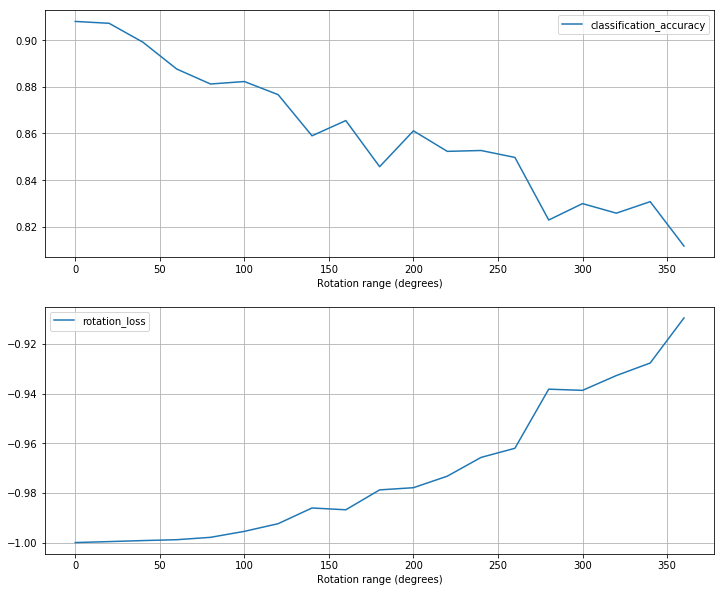

In [21]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.grid()
plt.plot(np.arange(0, 190, 10) * 2, data[:, 4], label='classification_accuracy')
plt.xlabel('Rotation range (degrees)')
plt.legend()
plt.subplot(212)
plt.grid()
plt.plot(np.arange(0, 190, 10) * 2, data[:, 1], label='rotation_loss')
plt.xlabel('Rotation range (degrees)')
plt.legend()

In [60]:
Y_pred, R_pred = model.predict(X_test_rot)

In [44]:
diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
diff_degree = np.array([diff if diff < 180 else diff - 180 for diff in diff_degree])

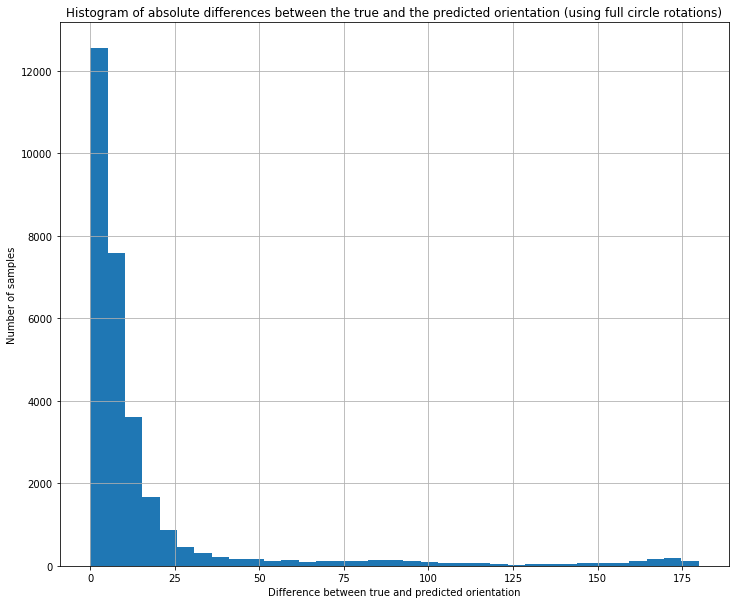

In [78]:
plt.figure(figsize=(12, 10))
plt.title('Histogram of absolute differences between the true and the predicted orientation (using full circle rotations)')
plt.hist(diff_degree, bins=35)
plt.grid()
plt.xlabel('Difference between true and predicted orientation')
plt.ylabel('Number of samples')
plt.show()

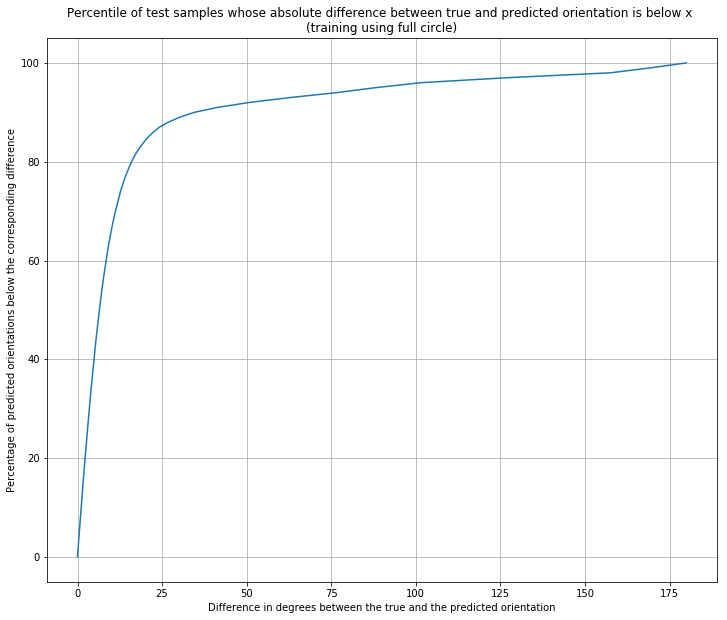

In [83]:
xv = np.arange(0, 101)
plt.figure(figsize=(12, 10))
plt.grid()
plt.plot([np.percentile(diff_degree, x) for x in xv], xv)
plt.title('Percentile of test samples whose absolute difference between true and predicted orientation is below x \n(training using full circle)')
plt.xlabel('Difference in degrees between the true and the predicted orientation')
plt.ylabel('Percentage of predicted orientations below the corresponding difference')
plt.show()

In [63]:
Y_pred = np.argmax(Y_pred, axis=1)

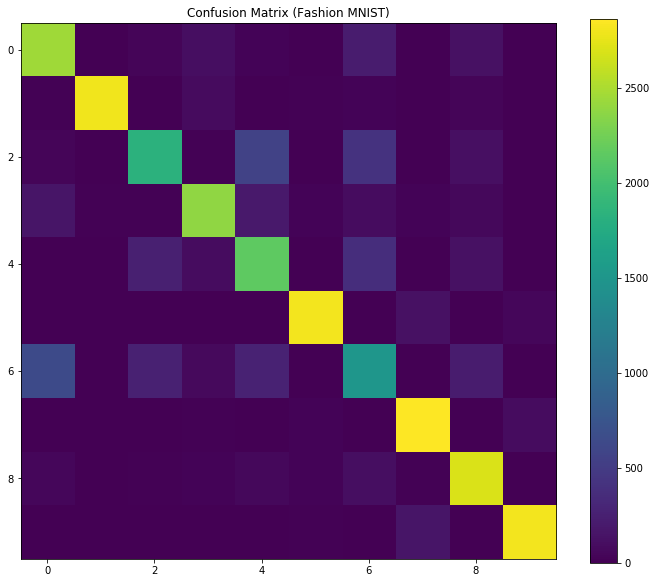

In [73]:
confusion_matrix = np.zeros((10, 10), dtype='int')

for y_true, y_pred in zip(Y_test_rot, Y_pred):
    confusion_matrix[y_true, y_pred] += 1

plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix (Fashion MNIST)')
plt.imshow(confusion_matrix)
plt.colorbar()